In [1]:
import os
import cv2
import laspy as lp
import numpy as np
import pyvista as pv 
import matplotlib.pyplot as plt

from PIL import Image
from scipy.interpolate import griddata
from numpy.polynomial.polynomial import Polynomial

In [2]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

def get_points_and_colors_from_las(las_path: str, limit: int = -1):
    if not isinstance(las_path, str):
        raise ValueError("las_path must be a string.")
    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    las = read_las_file(las_path)
    if las is None:
        raise ValueError("No valid LAS file found.")

    points = np.vstack((las.x, las.y, las.z)).transpose()
    colors = np.vstack((las.red, las.green, las.blue)).transpose()

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]

    rgba_colors = normalize_colors(colors)
    return points, colors, rgba_colors, np.expand_dims(las.classification, -1)

In [30]:
POOL_NAME = '2B'
PROJECT_NAME = '250111_Pools_100kHz_120m'
PATH_PROJECT_LAS = f'data/{PROJECT_NAME}/{POOL_NAME}_clasificada_col_0_row_0_19s.las'
OUTPUTS_PATH = f'discrete_model/{PROJECT_NAME}/{POOL_NAME}'
LIMIT = -1
DELTA_WATER = 0.05

if not os.path.exists(OUTPUTS_PATH):
    os.makedirs(OUTPUTS_PATH)

In [31]:
las_points, las_colors, las_rgba_colors, las_clasification = get_points_and_colors_from_las(PATH_PROJECT_LAS, limit=LIMIT)
las_points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(las_points[:,:3])

las_data_points = np.hstack((las_points_norm, las_rgba_colors, las_clasification))

other_points = las_data_points[las_data_points[:,-1] != 65]
water_points = las_data_points[las_data_points[:,-1] == 65]

mean_of_water_points = np.mean(water_points[:,2], axis=0)
height_water = np.percentile(water_points[:,2], 99)

X = other_points[:, 0]
Y = other_points[:, 1]
Z = other_points[:, 2]

distances = Z - mean_of_water_points

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -DELTA_WATER
above_plane = distances >= DELTA_WATER

points_below = np.column_stack((X[below_plane], Y[below_plane], Z[below_plane]))
points_above = np.column_stack((X[above_plane], Y[above_plane], Z[above_plane]))

In [32]:
import numpy as np
from scipy.spatial import KDTree

def remove_low_density_points(points_below, radius=0.1, min_neighbors=5):
    """
    Remove points from points_below that have fewer neighbors than min_neighbors within the specified radius.

    Parameters:
    points_below (np.ndarray): Array of points below the plane.
    radius (float): Radius within which to search for neighbors.
    min_neighbors (int): Minimum number of neighbors required to keep a point.

    Returns:
    np.ndarray: Array of points with low-density points removed.
    """
    # Create a KDTree from the points_below
    tree = KDTree(points_below)

    # Find the neighbors within the specified radius for each point
    distances, indices = tree.query(points_below, k=min_neighbors, distance_upper_bound=radius)

    # Create a mask for points that have the required number of neighbors within the radius
    mask = np.all(distances < radius, axis=1)

    # Return the points that meet the density criterion
    return points_below[mask]

points_below = remove_low_density_points(points_below)

In [33]:

# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos por encima del plano en rojo
points_above_pv = pv.PolyData(points_above)
plotter.add_points(points_above_pv, color='red', point_size=5)

# Añadir los puntos de agua en amarillo
water_points_pv = pv.PolyData(water_points[:,:3])
plotter.add_points(water_points_pv, color='yellow', point_size=5)

# Añadir la superficie del plano al plotter
plane = pv.Plane(center=[0.5, 0.5, mean_of_water_points], direction=[0, 0, 1], i_size=1, j_size=1)
plotter.add_mesh(plane, color='blue')

# Mostrar el plotter
plotter.show()



Widget(value='<iframe src="http://localhost:36491/index.html?ui=P_0x76a0bb202740_6&reconnect=auto" class="pyvi…

In [34]:
# Calcular las diagonales principales y secundarias
x_min_below = np.min(points_below[:, 0])
x_max_below = np.max(points_below[:, 0])
y_min_below = np.min(points_below[:, 1])
y_max_below = np.max(points_below[:, 1])

# Diagonal principal (de (x_min, y_min) a (x_max, y_max))
diagonal1 = np.array([x_min_below, y_min_below, 0]), np.array([x_max_below, y_max_below, 0])

# Diagonal secundaria (de (x_min, y_max) a (x_max, y_min))
diagonal2 = np.array([x_min_below, y_max_below, 0]), np.array([x_max_below, y_min_below, 0])

# Función para calcular la distancia de un punto a una línea
def distance_to_line(points, line_start, line_end):
    x0, y0, z0 = points[:, 0], points[:, 1], points[:, 2]
    x1, y1, z1 = line_start
    x2, y2, z2 = line_end
    numerator = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

# Umbral de distancia para considerar que un punto está en la diagonal
threshold = 0.01

# Identificar los puntos que pertenecen a las diagonales
distances_diagonal1 = distance_to_line(points_below, diagonal1[0], diagonal1[1])
distances_diagonal2 = distance_to_line(points_below, diagonal2[0], diagonal2[1])

points_on_diagonal1 = points_below[distances_diagonal1 < threshold]
points_on_diagonal2 = points_below[distances_diagonal2 < threshold]

points_on_diagonal1 = remove_low_density_points(points_on_diagonal1, radius=threshold, min_neighbors=10)
points_on_diagonal2 = remove_low_density_points(points_on_diagonal2, radius=threshold, min_neighbors=10)

# Crear un plotter de PyVista
plotter = pv.Plotter()

# Añadir los puntos por debajo del plano en verde
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos en las diagonales en azul
points_on_diagonal1_pv = pv.PolyData(points_on_diagonal1)
points_on_diagonal2_pv = pv.PolyData(points_on_diagonal2)
plotter.add_points(points_on_diagonal1_pv, color='blue', point_size=10)
plotter.add_points(points_on_diagonal2_pv, color='red', point_size=10)

# Mostrar el plotter
plotter.show()

Widget(value='<iframe src="http://localhost:36491/index.html?ui=P_0x76a0a6f86b00_7&reconnect=auto" class="pyvi…

/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/yeriel/workspace/sqm_batimetria/env/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1436: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


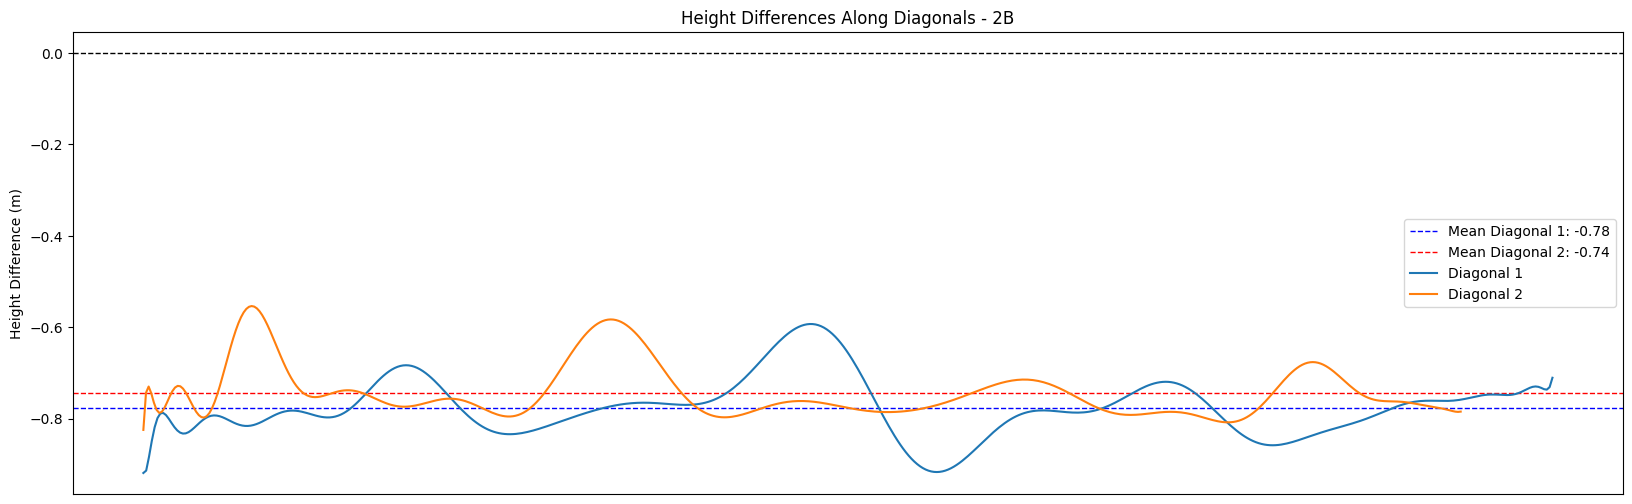

In [35]:
z_d1 = (height_water - points_on_diagonal1[:,2]) * (z_max - z_min) * -1
z_d2 = (height_water - points_on_diagonal2[:,2]) * (z_max - z_min) * -1
z_d2 = z_d2[::-1]

degree = 30  
poly_d1 = Polynomial.fit(np.arange(len(z_d1)), z_d1, degree)
poly_d2 = Polynomial.fit(np.arange(len(z_d2)), z_d2, degree)

x_new_d1 = np.linspace(0, len(z_d1) - 1, 500)
x_new_d2 = np.linspace(0, len(z_d2) - 1, 500)
z_new_d1 = poly_d1(x_new_d1)
z_new_d2 = poly_d2(x_new_d2)

mean_diagonal1 = np.mean(z_d1)
mean_diagonal2 = np.mean(z_d2)

plt.figure(figsize=(20, 6))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1, label=f'Mean Diagonal 1: {mean_diagonal1:.2f}')
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1, label=f'Mean Diagonal 2: {mean_diagonal2:.2f}')
plt.plot(x_new_d1, z_new_d1, label='Diagonal 1')
plt.plot(x_new_d2, z_new_d2, label='Diagonal 2')
plt.ylabel('Height Difference (m)')
plt.title(f'Height Differences Along Diagonals - {POOL_NAME}')
plt.xticks([])
plt.legend()
plt.savefig(f'{OUTPUTS_PATH}/{POOL_NAME}_diagonals.png')
plt.show()

In [36]:
import json

file = {
    "height_water_normalized": height_water,
    "denormalize" : {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "z_min": z_min,
        "z_max": z_max
    },
    "diagonal1" : {
        "x_axis": x_new_d1.tolist(),
        "y_axis": z_new_d1.tolist(),
        "mean": mean_diagonal1,
        "unit": "[m]"
    },
    "diagonal2" : {
        "x_axis": x_new_d2.tolist(),
        "y_axis": z_new_d1.tolist(),
        "mean": mean_diagonal2,
        "unit": "[m]"
    }
}

with open(f'{OUTPUTS_PATH}/{POOL_NAME}.json', 'w') as json_file:
    json.dump(file, json_file, indent=4)

Grid Resolution: 2024 x 4838


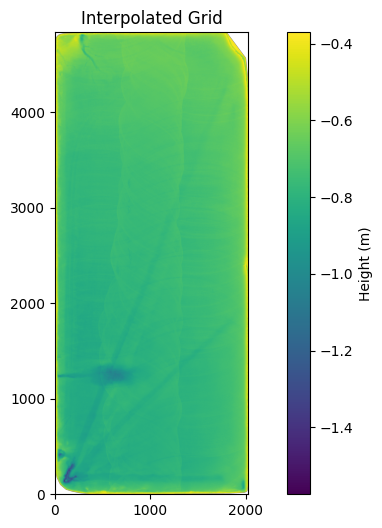

In [37]:
z_below = points_below[:,2] 
z = (height_water - z_below) * (z_max - z_min)

h1 = points_below_pv
h0 = water_points_pv

# Assume h0 and h1 are both PyVista point clouds
x0, y0, z0 = h0.points[:, 0], h0.points[:, 1], h0.points[:, 2]
x1, y1, z1 = h1.points[:, 0], h1.points[:, 1], h1.points[:, 2]

# Step 5: Interpolate onto a regular grid for DEM visualization
grid_res_x = 2024 # Adjust resolution
x1_min, x1_max = x1.min(), x1.max()
y1_min, y1_max = y1.min(), y1.max()
grid_res_y = int(grid_res_x * (y_max - y_min) / (x_max - x_min))
print(f"Grid Resolution: {grid_res_x} x {grid_res_y}")

grid_x, grid_y = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res_x),
    np.linspace(y1_min, y1_max, grid_res_y)
)

grid_z = griddata((x1, y1), z, (grid_x, grid_y), method="linear")*-1

plt.figure(figsize=(10, 6))
plt.imshow(grid_z, origin='lower', cmap='viridis')
plt.colorbar(label='Height (m)')
plt.title('Interpolated Grid')
plt.show()

In [38]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 
cv2.imwrite(f'{OUTPUTS_PATH}/{POOL_NAME}.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'{OUTPUTS_PATH}/{POOL_NAME}.tiff')